In [28]:
import os
import pandas as pd


def load_inputs_by_lang(source_file_dir):
    """Load input texts for each target language."""
    inputs = {}
    for tgt_lang in ["de", "fr", "es"]:
        path = os.path.join(source_file_dir, f"en-{tgt_lang}", "tst-COMMON.200.en")
        with open(path, 'r', encoding='utf-8') as f:
            inputs[tgt_lang] = [line.strip() for line in f.readlines()]
    return inputs


def parse_filename(file_name):
    """Parse a file name into its metadata components."""
    n_shots_raw, direction, model, pool_type, prompt_type, iteration_str, _ = file_name.split(".")
    n_shots = int(n_shots_raw.split("-")[0])
    iteration = int(iteration_str)
    src_lang, tgt_lang = direction.split("-")
    return n_shots, direction, model, pool_type, prompt_type, iteration + 1, src_lang, tgt_lang


def load_instances(directory, source_file_dir):
    """Load instance-level data from tab-separated prediction files and source inputs."""
    inputs_by_lang = load_inputs_by_lang(source_file_dir)

    all_rows = []

    for file_name in sorted(os.listdir(directory)):
        path = os.path.join(directory, file_name)
        with open(path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        outputs = []
        for line in lines:
            parts = line.split("\t")
            if len(parts) == 2:
                end_index = parts[1].find("<NL>")
                outputs.append(parts[1][:end_index].strip())
            else:
                outputs.append("")

        n_shots, direction, model, pool_type, prompt_type, iteration, src_lang, tgt_lang = parse_filename(file_name)
        input_texts = inputs_by_lang[tgt_lang]

        for idx, (src, out) in enumerate(zip(input_texts, outputs), 1):
            ratio = len(out) / len(src) if len(src) > 0 else 0.0
            all_rows.append({
                'file_name': file_name,
                'instance_index': idx,
                'n_shots': n_shots,
                'direction': direction,
                'model': model,
                'pool_type': pool_type,
                'prompt_type': prompt_type,
                'iteration': iteration,
                'src_lang': src_lang,
                'tgt_lang': tgt_lang,
                'ratio': ratio,
                'inputs': src,
                'outputs': out,
            })

    return pd.DataFrame(all_rows)


def load_eval_data(tsv_file):
    """Load evaluation-level metrics (BLEU, BERTScore, LC, Ratio) from result TSVs."""
    rows = []

    with open(tsv_file, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                path, bleu, bert_score, lc, ratio, *_ = line.strip().split("\t")
                _, dataset, experiment, setting = path.strip().split("/")
                n_shots_raw, direction, model, pool_type, prompt_type, iteration_str, _ = setting.split(".")
            except ValueError:
                continue

            n_shots = int(n_shots_raw.split("-")[0])
            iteration = int(iteration_str)
            src_lang, tgt_lang = direction.split("-")

            rows.append({
                'n_shots': n_shots,
                'direction': direction,
                'model': model,
                'pool_type': pool_type,
                'prompt_type': prompt_type,
                'iteration': iteration + 1,
                'dataset': dataset,
                'src_lang': src_lang,
                'tgt_lang': tgt_lang,
                'bleu': float(bleu),
                'bert_score': float(bert_score) * 100,
                'lc': float(lc),
                'ratio': float(ratio),
                'experiment': experiment
            })

    return pd.DataFrame(rows)

# Statistics

In [29]:
import math
import numpy as np
import os


def read_examples(src_file: str, tgt_file: str) -> list[tuple[str, str]]:
    """Reads source and target sentence pairs."""
    with open(src_file, "r", encoding="utf-8") as f_src, open(tgt_file, "r", encoding="utf-8") as f_tgt:
        src_lines = f_src.readlines()
        tgt_lines = f_tgt.readlines()

    return [(src.strip(), tgt.strip()) for src, tgt in zip(src_lines, tgt_lines)]


def filter_examples(
    examples: list[tuple[str, str]],
    ratio_from: float,
    ratio_to: float,
    sorting_type: str | None = None,
    top_n: int | None = None,
) -> list[tuple[str, str]]:
    """
    Filters sentence pairs based on target/source length ratio and optionally sorts + selects top N.
    """
    filtered = []
    for src, tgt in examples:
        src_len = len(src)
        tgt_len = len(tgt)
        if math.ceil(src_len * ratio_from) <= tgt_len <= math.floor(src_len * ratio_to):
            filtered.append((src, tgt))

    if top_n is not None:
        if sorting_type == "isometric":
            # Closest to ratio 1
            filtered = sorted(filtered, key=lambda pair: abs(1 - len(pair[1]) / len(pair[0])))
        elif sorting_type == "shorter":
            # Shortest relative to source
            filtered = sorted(filtered, key=lambda pair: len(pair[1]) / len(pair[0]))
        filtered = filtered[:top_n]

    return filtered


def compute_ratios(examples: list[tuple[str, str]]) -> list[float]:
    """Computes target-to-source length ratios."""
    return [len(tgt) / len(src) for src, tgt in examples if len(src) > 0]


def print_pool_stats(language: str, pool_name: str, examples: list[tuple[str, str]]):
    """Prints statistics for a pool of filtered examples."""
    ratios = compute_ratios(examples)
    if not ratios:
        print(f"{pool_name} & 0 & - & - & - \\\\")
        return

    mean_ratio = np.mean(ratios)
    std_ratio = np.std(ratios)
    min_ratio = min(ratios)
    max_ratio = max(ratios)
    print(f"{pool_name} & {len(examples)} & {min_ratio:.2f} & {max_ratio:.2f} & {mean_ratio:.2f}$\\pm${std_ratio:.2f} \\\\")


def process_language(language: str):
    print(language)
    source_file = f"../data/must-c/en-{language}/dev.en"
    target_file = f"../data/must-c/en-{language}/dev.{language}"
    examples = read_examples(source_file, target_file)

    pool_configs = {
        "ISOMETRIC":        dict(ratio_from=0.9, ratio_to=1.1, sorting_type="isometric", top_n=None),
        "ISOMETRIC-LOW":    dict(ratio_from=0.9, ratio_to=1.0, sorting_type="isometric", top_n=None),
        "ISOMETRIC-TOP-N":  dict(ratio_from=0.9, ratio_to=1.0, sorting_type="isometric", top_n=50),
        "SHORTER":          dict(ratio_from=0.0, ratio_to=1.0, sorting_type="shorter", top_n=None),
        "SHORTER-TOP-N":    dict(ratio_from=0.0, ratio_to=1.0, sorting_type="shorter", top_n=50),
        "RANDOM":           None  # No filtering
    }

    for pool_name, config in pool_configs.items():
        if config is None:
            filtered = examples
        else:
            filtered = filter_examples(examples, **config)

        print_pool_stats(language, pool_name, filtered)

for lang in ["de", "fr", "es"]:
    process_language(lang)

de
ISOMETRIC & 537 & 0.90 & 1.10 & 1.02$\pm$0.05 \\
ISOMETRIC-LOW & 223 & 0.90 & 1.00 & 0.96$\pm$0.03 \\
ISOMETRIC-TOP-N & 50 & 0.99 & 1.00 & 1.00$\pm$0.00 \\
SHORTER & 343 & 0.43 & 1.00 & 0.90$\pm$0.11 \\
SHORTER-TOP-N & 50 & 0.43 & 0.81 & 0.68$\pm$0.11 \\
RANDOM & 1415 & 0.43 & 5.80 & 1.14$\pm$0.27 \\
fr
ISOMETRIC & 505 & 0.90 & 1.10 & 1.02$\pm$0.05 \\
ISOMETRIC-LOW & 203 & 0.90 & 1.00 & 0.96$\pm$0.03 \\
ISOMETRIC-TOP-N & 50 & 0.99 & 1.00 & 1.00$\pm$0.00 \\
SHORTER & 348 & 0.29 & 1.00 & 0.88$\pm$0.14 \\
SHORTER-TOP-N & 50 & 0.29 & 0.76 & 0.60$\pm$0.13 \\
RANDOM & 1412 & 0.29 & 4.90 & 1.14$\pm$0.28 \\
es
ISOMETRIC & 659 & 0.90 & 1.10 & 1.01$\pm$0.05 \\
ISOMETRIC-LOW & 302 & 0.90 & 1.00 & 0.96$\pm$0.03 \\
ISOMETRIC-TOP-N & 50 & 1.00 & 1.00 & 1.00$\pm$0.00 \\
SHORTER & 490 & 0.30 & 1.00 & 0.89$\pm$0.12 \\
SHORTER-TOP-N & 50 & 0.30 & 0.72 & 0.59$\pm$0.12 \\
RANDOM & 1316 & 0.30 & 5.70 & 1.08$\pm$0.32 \\


# Experiments
## Match vs no-match

In [30]:
import pandas as pd
from scipy.stats import ttest_ind

MATCH_LABELS = ["Match", "No Match"]
DIRECTIONS = ['en-de', 'en-fr', 'en-es']
POOL_TYPES = ['RANDOM', 'ISOMETRIC', 'ISOMETRIC-TOP-N', 'SHORTER', 'SHORTER-TOP-N']

def compute_grouped_means(instance_data):
    # Assign match labels
    instance_data['match'] = instance_data['file_name'].apply(
        lambda row: 'No Match' if 'no-match' in row else 'Match'
    )

    # Group by relevant identifiers and compute average ratio
    return (
        instance_data
        .groupby(['model', 'direction', 'pool_type', 'instance_index', 'match'])['ratio']
        .mean()
        .reset_index()
    )

def merge_match_no_match(grouped_df):
    match_df = grouped_df[grouped_df['match'] == 'Match']
    no_match_df = grouped_df[grouped_df['match'] == 'No Match']

    merged = match_df.merge(
        no_match_df,
        on=["model", "direction", "instance_index", "pool_type"],
        suffixes=('_match', '_no_match')
    )
    return merged


def compute_ttest_summary(merged_df):
    # Compute means and p-values grouped by model/direction/pool_type
    summary = merged_df.groupby(['direction', 'model', 'pool_type'])[
        ['ratio_match', 'ratio_no_match']
    ].mean()

    summary['pvalue'] = merged_df.groupby(['direction', 'model', 'pool_type'])[
        ['ratio_match', 'ratio_no_match']
    ].apply(lambda x: ttest_ind(x['ratio_match'], x['ratio_no_match']).pvalue)

    return summary


def print_latex_table(ttest_summary):
    for direction in DIRECTIONS:
        models = ttest_summary.loc[direction].index.get_level_values('model').unique()
        for model in models:
            print(f"\\texttt{{{model}}}", end="")

            for pool_type in POOL_TYPES:
                try:
                    row = ttest_summary.loc[(direction, model, pool_type)]
                    match_val = row['ratio_match']
                    no_match_val = row['ratio_no_match']
                    pval = row['pvalue']

                    if pval < 0.1:
                        print(f" & \\underline{{{no_match_val:.3f}}} & \\underline{{{match_val:.3f}}}", end="")
                    else:
                        print(f" & {no_match_val:.3f} & {match_val:.3f}", end="")
                except KeyError:
                    print(" & -- & --", end="")  # fallback if a tuple is missing
            print(" \\\\")
        print()


instance_data = load_instances("../outputs/must-c/match-vs-no-match/", "../data/must-c/")
grouped = compute_grouped_means(instance_data)
merged = merge_match_no_match(grouped)
ttest_summary = compute_ttest_summary(merged)
print_latex_table(ttest_summary)

\texttt{gemma2:27b} & 1.100 & 1.097 & 1.099 & 1.094 & 1.098 & 1.097 & \underline{1.087} & \underline{1.011} & \underline{1.066} & \underline{0.955} \\
\texttt{gemma2:9b} & 1.108 & 1.106 & 1.106 & 1.101 & \underline{1.106} & \underline{1.073} & \underline{1.099} & \underline{1.026} & \underline{1.080} & \underline{0.981} \\
\texttt{llama3:70b} & 1.149 & 1.151 & 1.149 & 1.139 & 1.141 & 1.134 & \underline{1.138} & \underline{1.005} & \underline{1.122} & \underline{0.905} \\
\texttt{llama3:8b} & 1.106 & 1.100 & 1.093 & 1.108 & 1.099 & 1.112 & \underline{1.085} & \underline{1.048} & \underline{1.056} & \underline{0.994} \\
\texttt{mistral:7b} & 1.133 & 1.129 & 1.126 & 1.128 & 1.135 & 1.125 & 1.121 & 1.105 & \underline{1.138} & \underline{1.085} \\
\texttt{mixtral:8x7b} & 1.402 & 1.411 & 1.375 & 1.362 & 1.378 & 1.381 & 1.385 & 1.297 & 1.363 & 1.265 \\
\texttt{qwen2:72b} & 1.223 & 1.169 & 1.195 & 1.178 & 1.184 & 1.173 & 1.170 & 1.128 & 1.164 & 1.129 \\
\texttt{qwen2:7b} & 1.132 & 1.160 & 1.14

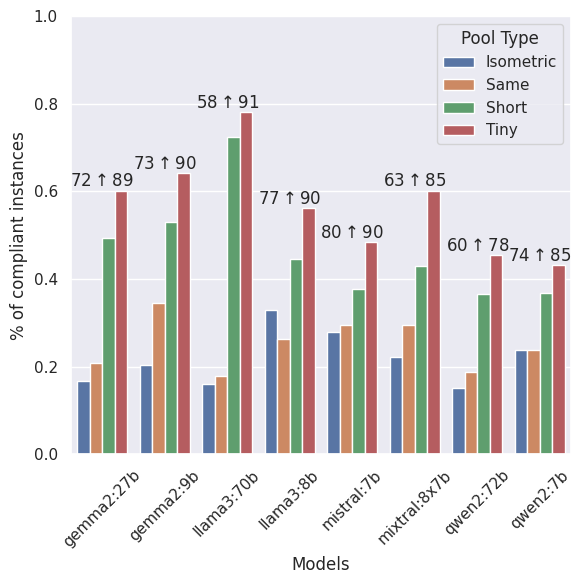

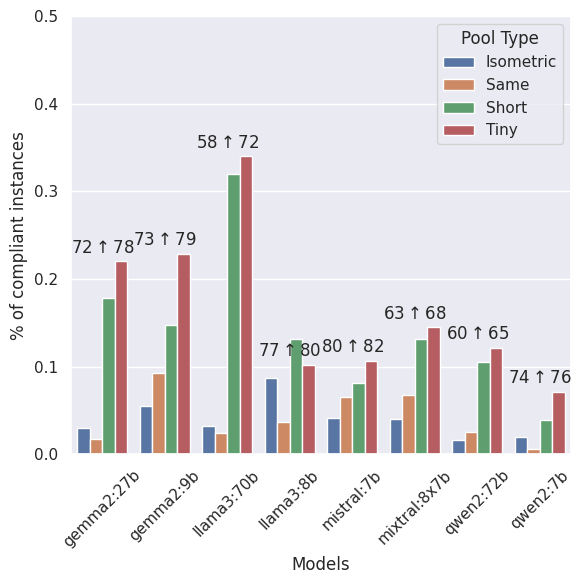

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Preprocess Compliance Flags ---

def mark_compliance(df):
    df["is_compliant"] = df["ratio"].between(0.9, 1.1).astype(int)
    df['cum_compliant'] = df.groupby(group_cols)["is_compliant"].cumsum()
    df['any_compliant'] = df.groupby(group_cols)["is_compliant"].transform('max')
    return df

group_cols = [
    'model', 'pool_type', 'prompt_type', 'n_shots', 'direction',
    'tgt_lang', 'src_lang', 'instance_index'
]

instance_data["is_compliant"] = instance_data["ratio"].apply(lambda x: 1 if 0.9 <= x <= 1.1 else 0)
instance_data = mark_compliance(instance_data)

# --- Step 2: Filter to relevant subset (iteration 10, matching prompts) ---

only_match = instance_data[
    ~instance_data["prompt_type"].str.contains("no-match") &
    (instance_data['iteration'] == 10) &
    (instance_data['inputs'].apply(len) > 10)
].copy()

only_match['setting'] = only_match['model'] + only_match['direction'] + only_match['instance_index'].astype(str)
only_match["pool_type"] = only_match["pool_type"].replace({
    "ISOMETRIC": "Isometric",
    "ISOMETRIC-TOP-N": "Same",
    "SHORTER": "Short",
    "SHORTER-TOP-N": "Tiny",
    "RANDOM": "Random",
})

# --- Step 3: Identify non-compliant examples in Random pool ---

def get_non_compliant_settings(df, flag_col):
    return df[(df[flag_col] == 0) & (df['pool_type'] == 'Random')]['setting'].unique()

non_compliant_settings = get_non_compliant_settings(only_match, 'any_compliant')
non_compliant_settings_raw = get_non_compliant_settings(only_match, 'is_compliant')

non_compliant_instances = only_match[only_match['setting'].isin(non_compliant_settings)]
non_compliant_instances_raw = only_match[only_match['setting'].isin(non_compliant_settings_raw)]

# --- Step 4: Helper Functions for Plotting ---

def compute_random_ratios(df, compliance_col, baseline_total=600):
    group = df[df['pool_type'] == 'Random'].groupby(['model', 'pool_type', compliance_col])['model'].count()
    return group.apply(lambda x: 1 - x / baseline_total).to_list()

def compute_compliant_proportions(df, pool='Tiny', compliance_col='any_compliant'):
    return df[df['pool_type'] == pool].groupby(['model', 'pool_type'])[compliance_col].mean().reset_index()[compliance_col].to_list()

def plot_compliance_bars(df, compliance_col, ylim, filename, ylabel):
    ratios = compute_random_ratios(df, compliance_col)
    proportions = compute_compliant_proportions(df, compliance_col=compliance_col)

    plt.figure(figsize=(6, 6))
    sns.set_theme()

    ax = sns.barplot(
        data=df,
        x='model',
        y=compliance_col,
        hue='pool_type',
        hue_order=['Isometric', 'Same', 'Short', 'Tiny'],
        errorbar=None
    )

    ax.set_ylim(0, ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Models')
    plt.legend(title='Pool Type', bbox_to_anchor=(1, 1), loc='upper right')
    plt.xticks(rotation=45)

    for i, ratio in enumerate(ratios):
        adjusted = ((1 - ratio) * proportions[i] + ratio) * 100
        plt.text(i, proportions[i] + 0.01, f"{(ratio*100):.0f}$\\uparrow${adjusted:.0f}", ha='center')

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# --- Step 5: Generate Plots ---

plot_compliance_bars(
    df=non_compliant_instances,
    compliance_col='any_compliant',
    ylim=1.0,
    filename='../figures/compliance.pdf',
    ylabel='% of compliant instances'
)

plot_compliance_bars(
    df=non_compliant_instances,
    compliance_col='is_compliant',
    ylim=0.5,
    filename='../figures/compliance.1-attempt.pdf',
    ylabel='% of compliant instances'
)

## Few-shot

/tmp/ipykernel_676846/204925767.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(title='BERTScore', loc='center left', bbox_to_anchor=(1.4, 0.5))


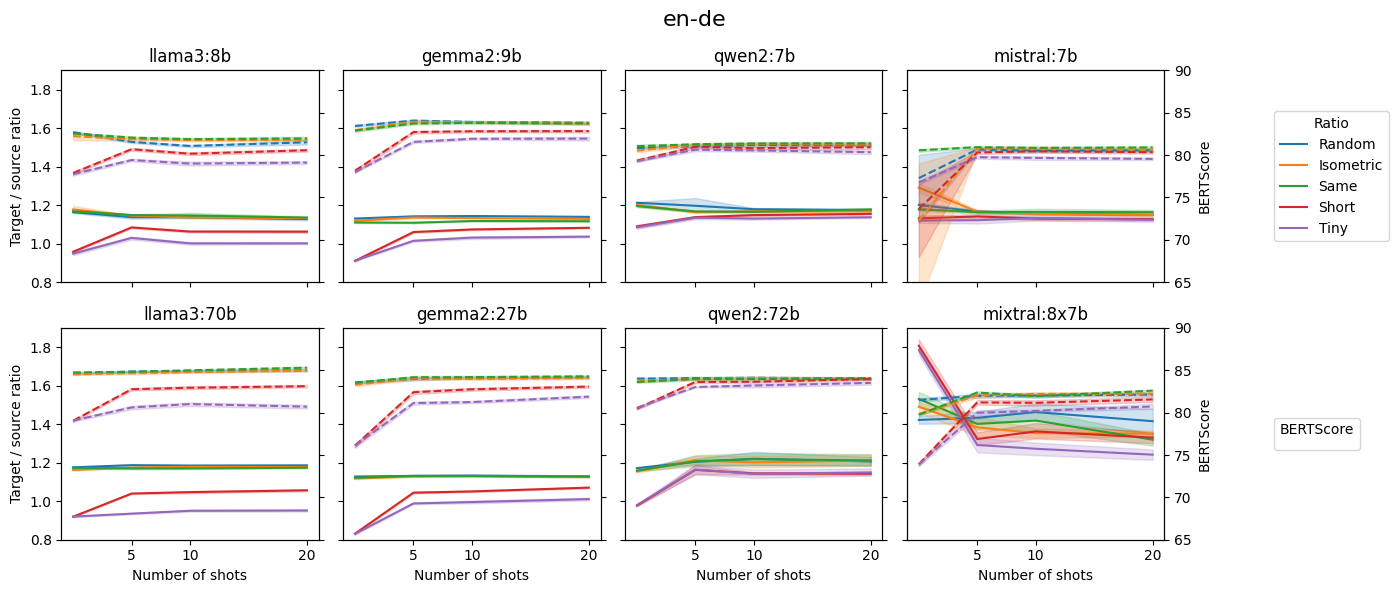

/tmp/ipykernel_676846/204925767.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(title='BERTScore', loc='center left', bbox_to_anchor=(1.4, 0.5))


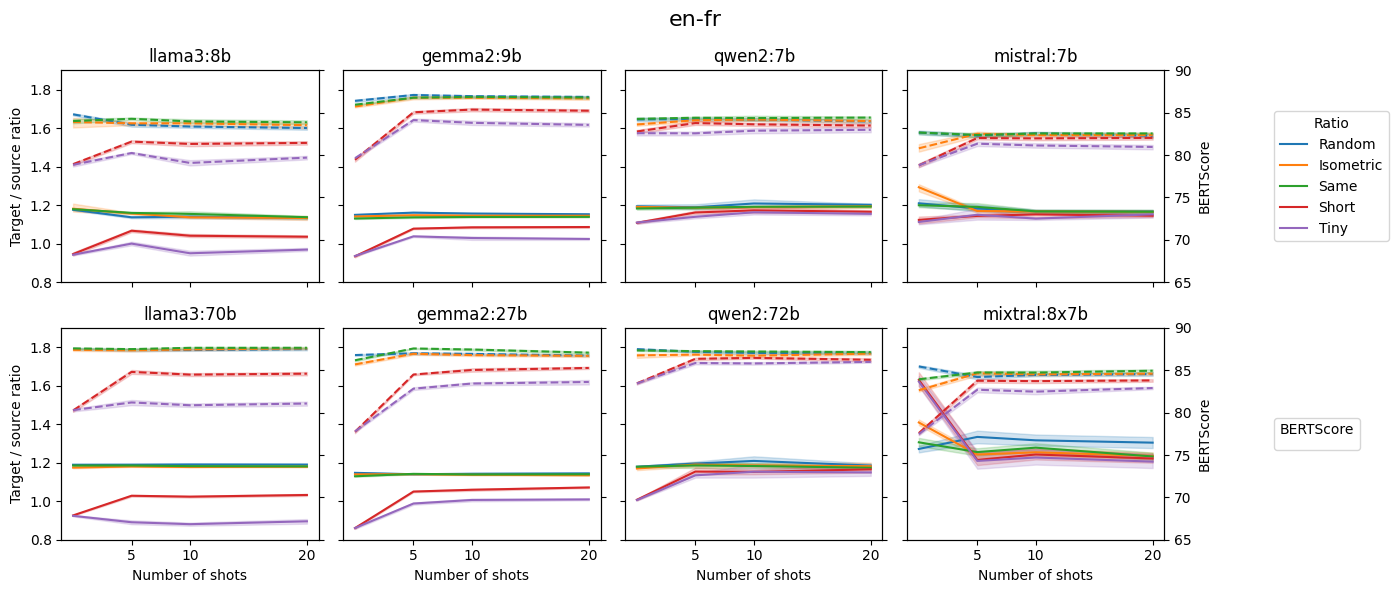

/tmp/ipykernel_676846/204925767.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(title='BERTScore', loc='center left', bbox_to_anchor=(1.4, 0.5))


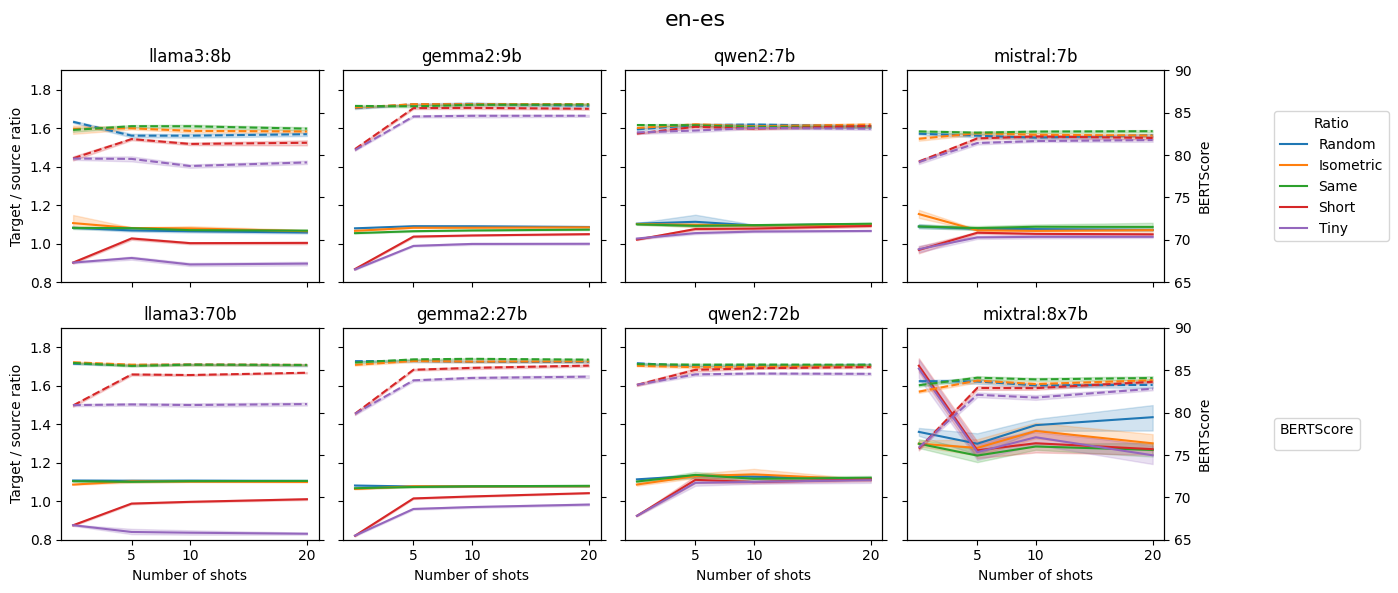

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
data = load_eval_data("../evaluation/few-shot/results.tsv")

# Define replacements and constants
language_pairs = ['en-de', 'en-fr', 'en-es']
data["pool_type"] = data["pool_type"].replace({
    "ISOMETRIC": "Isometric",
    "ISOMETRIC-TOP-N": "Same",
    "SHORTER": "Short",
    "SHORTER-TOP-N": "Tiny",
    "RANDOM": "Random",
})

pool_order = ['Random', 'Isometric', 'Same', 'Short', 'Tiny']
model_names = [
    "llama3:8b", "gemma2:9b", "qwen2:7b", "mistral:7b",
    "llama3:70b", "gemma2:27b", "qwen2:72b", "mixtral:8x7b"
]

def plot_model_subplot(data, model, index):
    """Draw one subplot with ratio and BERTScore for a given model index"""
    plt.subplot(2, 4, index + 1)

    model_data = data[data['model'] == model]

    # Primary axis: Ratio
    ax1 = sns.lineplot(
        data=model_data, x='n_shots', y='ratio', hue='pool_type',
        hue_order=pool_order, legend=False if index != 3 else True
    )
    ax1.set_ylim(0.8, 1.9)
    ax1.set_title(model)
    ax1.set_xticks([5, 10, 20])

    # Hide or show y-axis for ratio
    if index in [1, 2, 3, 5, 6, 7]:
        ax1.set_ylabel('')
        ax1.set_yticklabels([])
    else:
        ax1.set_ylabel('Target / source ratio')

    if index < 4:
        ax1.set_xlabel('')
        ax1.set_xticklabels([])
    else:
        ax1.set_xlabel('Number of shots')

    # Secondary axis: BERTScore
    ax2 = ax1.twinx()
    ax2 = sns.lineplot(
        data=model_data, x='n_shots', y='bert_score', hue='pool_type',
        hue_order=pool_order, ax=ax2, legend=False
    )
    ax2.set_ylim(65, 90)

    # Style BERTScore lines
    for line in ax2.lines:
        line.set_linestyle('--')

    # Hide or show BERTScore y-axis
    if index in [0, 1, 2, 4, 5, 6]:
        ax2.set_ylabel('')
        ax2.set_yticklabels([])
    else:
        ax2.set_ylabel('BERTScore')

    # Add legends selectively
    if index == 3:
        ax1.legend(title='Ratio', loc='center left', bbox_to_anchor=(1.4, 0.5))
    if index == 7:
        ax2.legend(title='BERTScore', loc='center left', bbox_to_anchor=(1.4, 0.5))

# Plot per language pair
for lang_pair in language_pairs:
    plt.figure(figsize=(14, 6))
    plt.suptitle(lang_pair, fontsize=16)

    filtered = data[data["direction"] == lang_pair]
    for i, model in enumerate(model_names):
        plot_model_subplot(filtered, model, i)

    plt.tight_layout()
    plt.savefig(f'../figures/ratio.pool_types.{lang_pair}.common-range.pdf')
    plt.show()


## Translation quality and length ratio trade-off

/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with

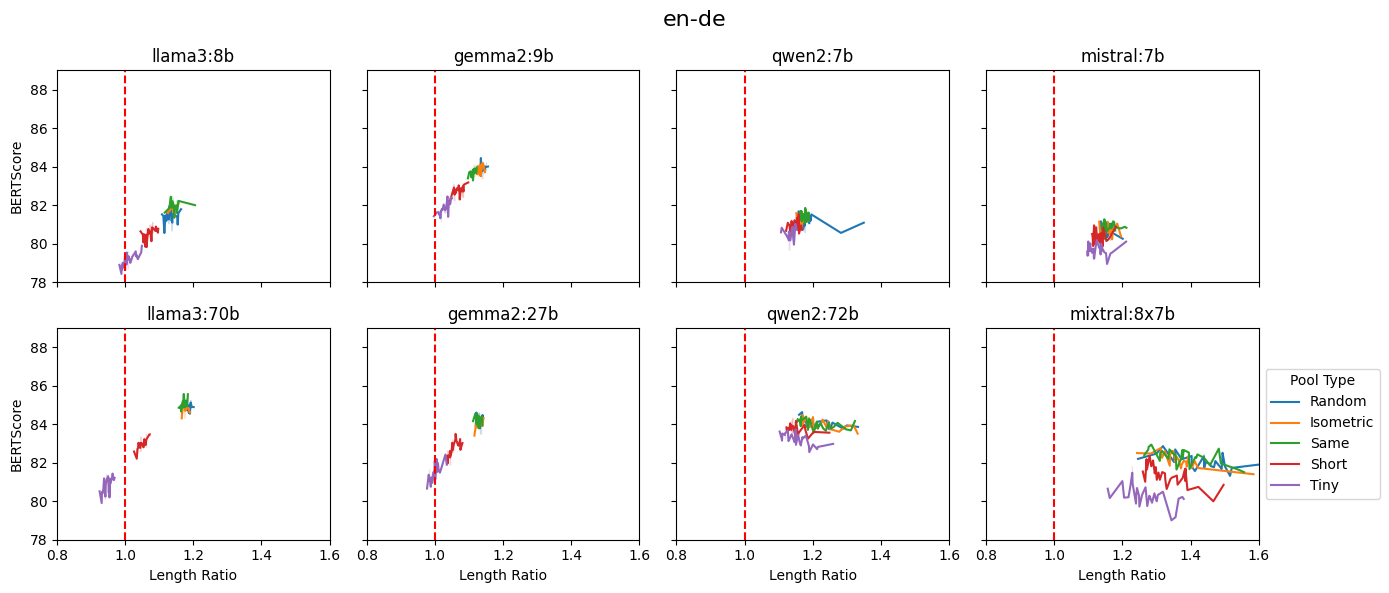

/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with

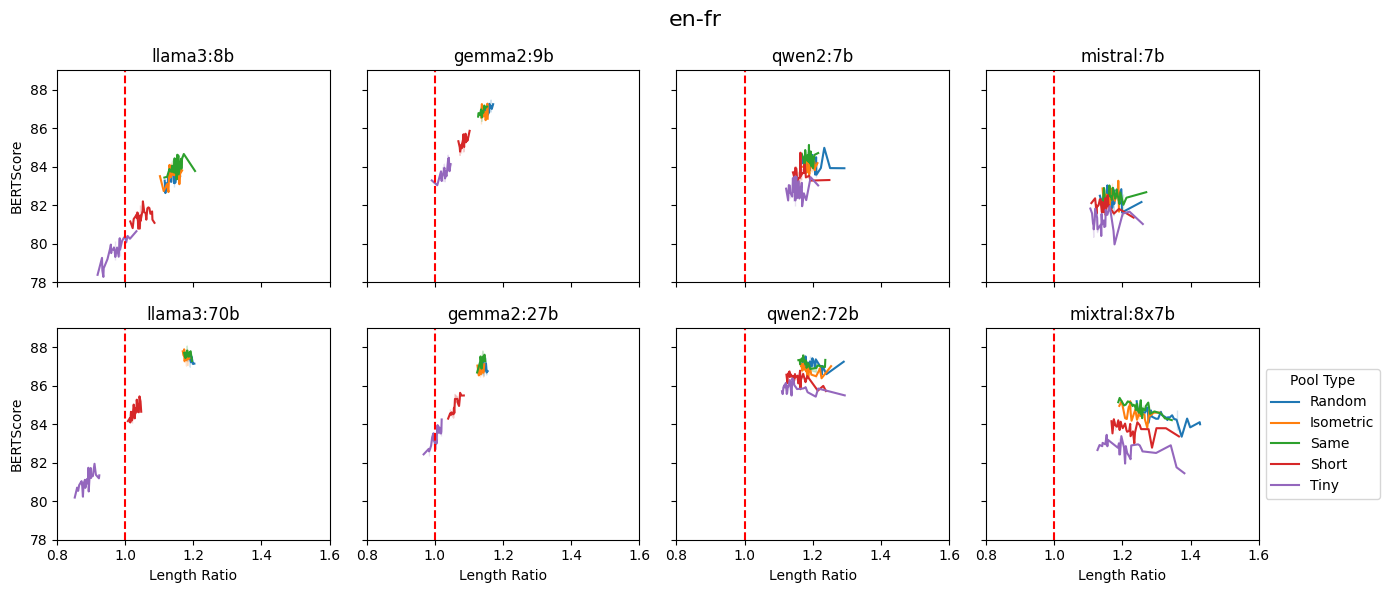

/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/tmp/ipykernel_676846/1800135361.py:59: UserWarning: No artists with

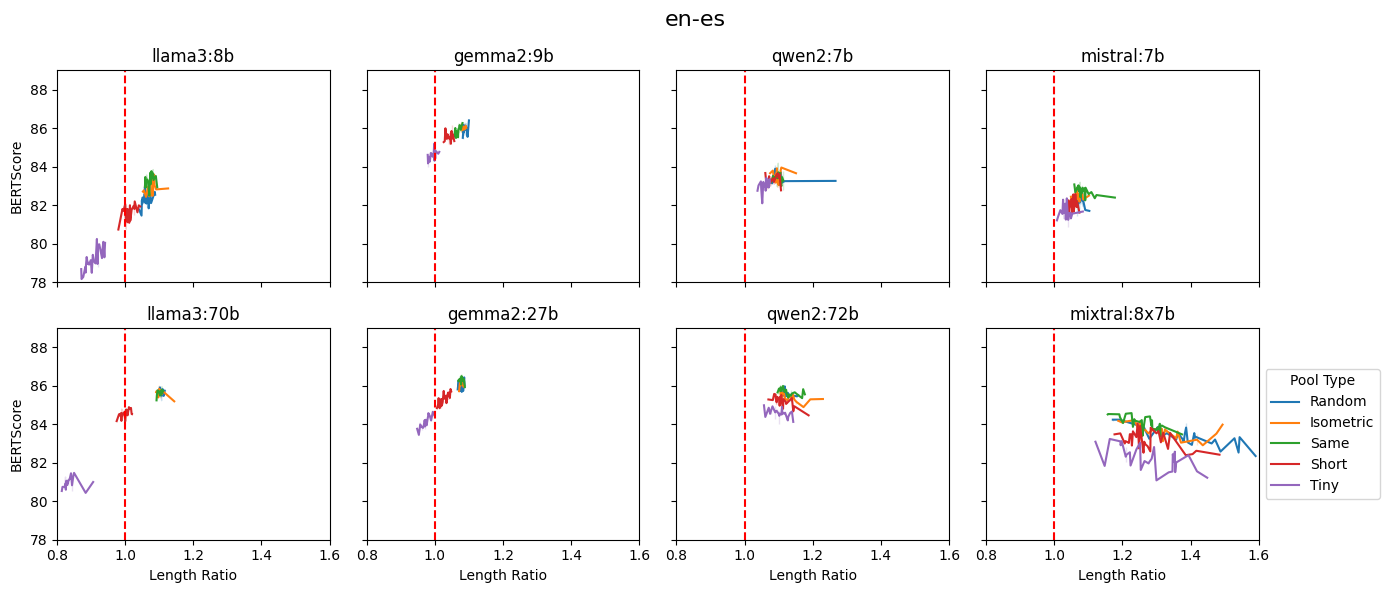

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the language pairs and model names
language_pairs = ['en-de', 'en-fr', 'en-es']
model_names = [
    "llama3:8b", "gemma2:9b", "qwen2:7b", "mistral:7b",
    "llama3:70b", "gemma2:27b", "qwen2:72b", "mixtral:8x7b",
]

pool_order = ['Random', 'Isometric', 'Same', 'Short', 'Tiny']  # Set hue order for consistency

def plot_tradeoff_per_language(language_pair, data):
    filtered_data = data[(data["direction"] == language_pair) & (data["n_shots"] != 0)]

    plt.figure(figsize=(14, 6))
    plt.suptitle(f'{language_pair}', fontsize=16)

    for i, model in enumerate(model_names):
        model_data = filtered_data[filtered_data["model"] == model]
        ax = plt.subplot(2, 4, i + 1)

        show_y = i in [0, 4]
        show_x = i >= 4
        show_legend = i == 7

        # Plot BERTScore vs length ratio
        line = sns.lineplot(
            data=model_data,
            x='ratio',
            y='bert_score',
            hue='pool_type',
            hue_order=pool_order,
            ax=ax,
            legend=show_legend
        )

        ax.set_xlim(0.8, 1.6)
        ax.set_ylim(78, 89)
        ax.axvline(x=1.0, color='red', linestyle='--')

        if not show_y:
            ax.set_ylabel("")
            ax.tick_params(axis='y', labelleft=False)
        else:
            ax.set_ylabel("BERTScore")

        if not show_x:
            ax.set_xlabel("")
            ax.tick_params(axis='x', labelbottom=False)
        else:
            ax.set_xlabel("Length Ratio")

        ax.set_title(model)
        if show_legend:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[:len(pool_order)], labels=pool_order, title="Pool Type", loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.savefig(f'../figures/tradeoff.models.{language_pair}.pdf')
    plt.show()

# Run the plots for each language
for language_pair in language_pairs:
    plot_tradeoff_per_language(language_pair, data)


# Final Evaluation

In [22]:
from collections import defaultdict

settings = defaultdict(list)

with open("../evaluation/final-evaluation/results.tsv", "r") as f:
    for line in f:
        path, bleu, bert_score, lc, ratio, lower, upper = line.strip().split("\t")
        _, dataset, experiment, setting = path.strip().split("/")
        n_shots, direction, model, pool_type, prompt_type, iteration, _ = setting.split(".")
        
        iteration = int(iteration)
        
        if iteration in [0, 2, 4, 9] and (("gemma" in model) or ("llama" in model)):
            values = [
                iteration + 1,
                float(ratio),
                float(lc),
                float(bert_score),
                float(bleu)
            ]
            key = f"\\texttt{{model={model}-k={iteration + 1}}}"
            settings[key].append(values)

# Format output as LaTeX table rows
for desc, value_list in settings.items():
    # Flatten the list of values (1 line per iteration)
    flat_values = [item for sublist in value_list for item in sublist]
    row = desc
    for i in range(0, len(flat_values), 5):
        _, ratio, lc, bs, bleu = flat_values[i:i+5]
        row += f" & {ratio:.2f} & {lc:.1f} & {bs*100:.2f} & {bleu:.1f}"
    row += " \\\\"
    print(row)


\texttt{model=gemma2:27b-k=1} & 1.07 & 43.5 & 77.08 & 19.0 & 1.05 & 47.5 & 78.30 & 32.7 & 1.00 & 55.5 & 83.20 & 40.3 \\
\texttt{model=gemma2:27b-k=3} & 1.08 & 58.0 & 77.96 & 20.2 & 1.07 & 60.5 & 79.96 & 33.5 & 1.01 & 66.5 & 83.29 & 40.3 \\
\texttt{model=gemma2:27b-k=5} & 1.09 & 62.5 & 77.98 & 20.4 & 1.06 & 62.5 & 80.01 & 33.9 & 1.02 & 68.0 & 83.16 & 40.0 \\
\texttt{model=gemma2:27b-k=10} & 1.08 & 68.5 & 77.84 & 21.9 & 1.08 & 69.0 & 80.05 & 35.6 & 1.01 & 70.5 & 83.62 & 40.8 \\
\texttt{model=gemma2:9b-k=1} & 2.24 & 42.5 & 77.04 & 17.7 & 0.00 & 0.0 & 0.00 & 0.0 & 1.02 & 54.5 & 82.47 & 39.0 \\
\texttt{model=gemma2:9b-k=3} & 1.19 & 58.5 & 77.24 & 20.6 & 1.07 & 60.5 & 80.38 & 34.1 & 1.03 & 65.5 & 83.41 & 36.8 \\
\texttt{model=gemma2:9b-k=5} & 1.07 & 64.5 & 77.38 & 20.9 & 1.06 & 65.5 & 80.66 & 35.5 & 1.03 & 73.0 & 83.30 & 37.2 \\
\texttt{model=gemma2:9b-k=10} & 1.08 & 64.0 & 77.48 & 21.7 & 1.06 & 70.5 & 80.72 & 34.9 & 1.03 & 73.0 & 83.17 & 37.6 \\
\texttt{model=llama3:70b-k=1} & 1.09 & 49.0 &

# Appendix
## A: Overgeneration

\texttt{mistral:7b} & 16 & 3 & 9 & 1 & 21 & 2 \\
\texttt{llama3:8b} & 100 & 2 & 100 & 2 & 100 & 0 \\
\texttt{gemma2:27b} & 100 & 0 & 100 & 2 & 100 & 2 \\
\texttt{qwen2:7b} & 0 & 0 & 0 & 0 & 0 & 0 \\
\texttt{gemma2:9b} & 100 & 0 & 100 & 2 & 100 & 1 \\
\texttt{qwen2:72b} & 13 & 2 & 6 & 0 & 6 & 2 \\
\texttt{llama3:70b} & 100 & 0 & 100 & 0 & 100 & 0 \\
\texttt{mixtral:8x7b} & 40 & 16 & 27 & 14 & 38 & 22 \\


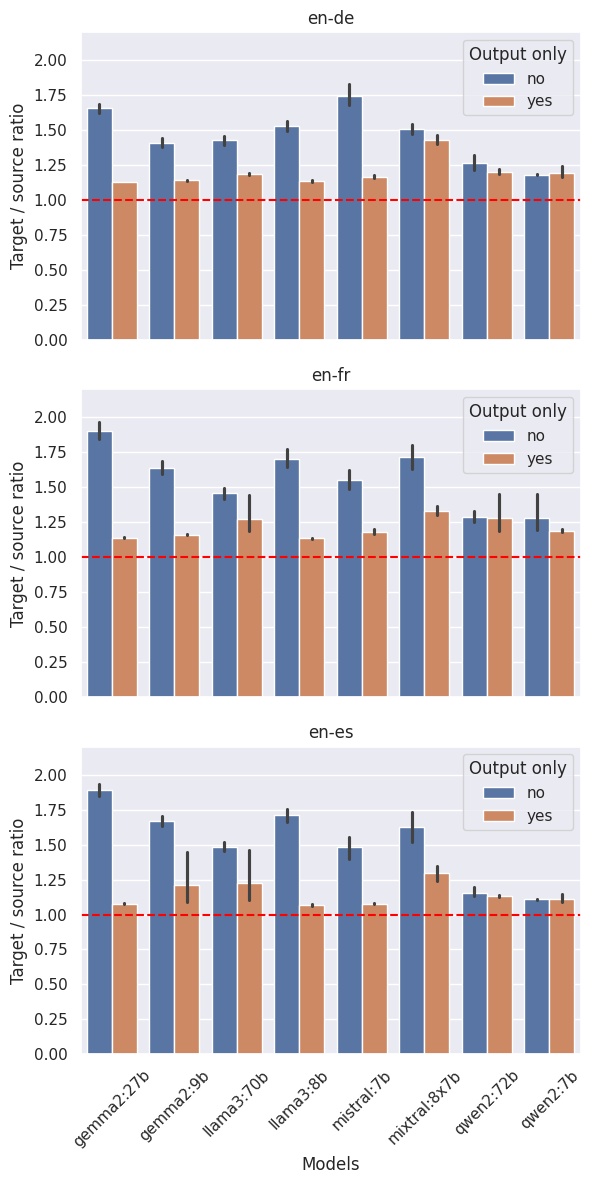

In [8]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def count_meaningful_new_lines(file_path: str) -> int:
    """Count lines where <NL> is used and followed by non-empty content."""
    count = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                translation = line.split("\t")[1].strip()
                if "<NL>" in translation:
                    after_nl = translation.split("<NL>", maxsplit=1)[1]
                    if after_nl.strip():
                        count += 1
            except IndexError:
                continue  # skip malformed lines
    return count


def summarize_new_lines(directory: str, num_instances: int = 200) -> dict:
    """
    Parse translation files and return a summary dict of models → [values for en-de, en-de-only, en-fr, en-fr-only, en-es, en-es-only].
    """
    summary = defaultdict(list)

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        count = count_meaningful_new_lines(filepath)
        setting = filename.replace(".tsv", "")
        summary[setting].append(count / num_instances)

    models_summary = {}

    for setting, values in summary.items():
        avg_percent = sum(values) / len(values) * 100
        parts = setting.split(".")

        _, direction, model_name, _, prompt_type, _, _ = parts

        if model_name not in models_summary:
            models_summary[model_name] = [0] * 6  # en-de, en-de-only, en-fr, en-fr-only, en-es, en-es-only

        idx_map = {"en-de": 0, "en-fr": 2, "en-es": 4}
        idx = idx_map.get(direction, None)
        if idx is None:
            continue

        if "ONLY" in prompt_type:
            idx += 1

        models_summary[model_name][idx] = avg_percent

    return models_summary


def print_newline_summary_table(models_summary: dict):
    """
    Print LaTeX-formatted row for each model based on newline summary.
    """
    for model, values in models_summary.items():
        row = " & ".join(f"{v:.0f}" for v in values)
        print(f"\\texttt{{{model}}} & {row} \\\\")


# --- Data & Plotting ---

# Load evaluation results
data = load_eval_data("../evaluation/restricted-vs-unrestricted/results.tsv")
data = data[data["pool_type"] != "ISOMETRIC-LOW"]
data = data[data["prompt_type"].str.contains("match")]

# Normalize pool type labels
data["pool_type"] = data["pool_type"].replace({
    "ISOMETRIC": "Iso",
    "ISOMETRIC-TOP-N": "Iso-N",
    "RANDOM": "Rand",
    "SHORTER": "Short",
    "SHORTER-TOP-N": "Short-N"
})

# Print newline summary table
newline_summary = summarize_new_lines("../outputs/must-c/restricted-vs-unrestricted/")
print_newline_summary_table(newline_summary)

# Plotting
language_pairs = ['en-de', 'en-fr', 'en-es']
settings = ['TEXTUAL-OUTPUT-UNRESTRICTED-match', 'TEXTUAL-OUTPUT-ONLY-match']

# Simplify prompt labels
filtered_data = data[data['direction'].isin(language_pairs) & data['prompt_type'].isin(settings)].copy()
filtered_data['prompt_type'] = filtered_data['prompt_type'].replace({
    'TEXTUAL-OUTPUT-UNRESTRICTED-match': 'no',
    'TEXTUAL-OUTPUT-ONLY-match': 'yes'
})

sns.set_theme()
plt.figure(figsize=(6, 12))

for i, lang in enumerate(language_pairs):
    plt.subplot(len(language_pairs), 1, i + 1)
    sns.barplot(
        data=filtered_data[filtered_data['direction'] == lang],
        x='model', y='ratio',
        hue='prompt_type',
        hue_order=['no', 'yes']
    )
    plt.title(lang)
    plt.ylim(0.0, 2.2)
    plt.axhline(y=1.0, color='red', linestyle='--')
    plt.ylabel('Target / source ratio')
    if i != len(language_pairs) - 1:
        plt.xticks([])
        plt.xlabel('')
    else:
        plt.xticks(rotation=45)
        plt.xlabel('Models')
    plt.legend(title='Output only')

plt.tight_layout()
plt.savefig('../figures/ratio.output_only_vs_unrestricted-truncated.pdf')
plt.show()

## C: Verbose results

In [ ]:
import pandas as pd

# Set number of shots for filtering
n_shots_filter = 20 # NOTE: Change this to 0, 5, 10 if needed

# Load and prepare data
data = load_eval_data("../evaluation/few-shot/results.tsv")

# Rename columns for LaTeX table presentation
data.rename(columns={
    'ratio': 'LR', 
    'lc': 'LC', 
    'bert_score': 'BS', 
    'bleu': 'BLEU'
}, inplace=True)

# Replace model and pool names with LaTeX-safe formatting
model_latex_map = {
    'gemma2:27b': '\\texttt{gemma2:27b}', 
    'gemma2:9b': '\\texttt{gemma2:9b}', 
    'llama3:70b': '\\texttt{llama3:70b}', 
    'llama3:8b': '\\texttt{llama3:8b}', 
    'mistral:7b': '\\texttt{mistral:7b}', 
    'mixtral:8x7b': '\\texttt{mixtral:8x7b}', 
    'qwen2:72b': '\\texttt{qwen2:72b}', 
    'qwen2:7b': '\\texttt{qwen2:7b}'
}

pool_type_latex_map = {
    'ISOMETRIC': '\\texttt{Isometric}', 
    'ISOMETRIC-TOP-N': '\\texttt{Same}', 
    'RANDOM': '\\texttt{Random}', 
    'SHORTER': '\\texttt{Short}', 
    'SHORTER-TOP-N': '\\texttt{Tiny}'
}

data['model'] = data['model'].replace(model_latex_map)
data['pool_type'] = data['pool_type'].replace(pool_type_latex_map)

# Aggregate metrics by model and pool type for each language
grouped_data_list = []
for direction in ["en-de", "en-fr", "en-es"]:
    filtered_data = data[
        (data["direction"] == direction) & 
        (data["n_shots"] == n_shots_filter)
    ]

    grouped = filtered_data.groupby(['model', 'pool_type'])[['LR', 'LC', 'BS', 'BLEU']].mean()
    grouped_data_list.append(grouped)

# Concatenate along columns (multi-language comparison)
concatenated_data = pd.concat(grouped_data_list, axis=1)
concatenated_data.columns = pd.MultiIndex.from_product(
    [["en-de", "en-fr", "en-es"], ['LR', 'LC', 'BS', 'BLEU']]
)

# Export or print LaTeX table
latex_table = concatenated_data.to_latex(
    float_format="%.2f",
    multirow=True,
    multicolumn=True,
    column_format="llcccccccccccc",
    escape=False
)
print(latex_table)


\begin{tabular}{llcccccccccccc}
\toprule
 &  & \multicolumn{4}{r}{en-de} & \multicolumn{4}{r}{en-fr} & \multicolumn{4}{r}{en-es} \\
 &  & LR & LC & BS & BLEU & LR & LC & BS & BLEU & LR & LC & BS & BLEU \\
model & pool_type &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{\texttt{gemma2:27b}} & \texttt{Isometric} & 1.13 & 39.70 & 84.08 & 33.24 & 1.14 & 39.60 & 86.71 & 42.21 & 1.08 & 48.90 & 86.05 & 38.70 \\
 & \texttt{Random} & 1.13 & 38.05 & 84.15 & 33.75 & 1.14 & 39.40 & 86.74 & 42.23 & 1.08 & 49.35 & 85.98 & 38.82 \\
 & \texttt{Same} & 1.13 & 39.15 & 84.29 & 33.68 & 1.14 & 42.50 & 87.08 & 42.86 & 1.08 & 49.85 & 86.26 & 39.03 \\
 & \texttt{Short} & 1.07 & 43.45 & 83.07 & 30.32 & 1.07 & 45.05 & 85.28 & 37.52 & 1.04 & 52.20 & 85.55 & 37.43 \\
 & \texttt{Tiny} & 1.01 & 42.00 & 81.88 & 27.16 & 1.01 & 40.90 & 83.62 & 33.65 & 0.98 & 48.55 & 84.25 & 34.32 \\
\cline{1-14}
\multirow[t]{5}{*}{\texttt{gemma2:9b}} & \texttt{Isometric} & 1.13 & 37.75 & 83.73 & 31.51 & 1.14 & 41.1